# 03 - Extraction - Geothermal Probes ZH
### Author: Daniel Herrera-Russert
#### January 28, 2025

In [2]:
# !pip install geopandas owslib requests pyproj

In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from owslib.wfs import WebFeatureService
import geopandas as gpd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyproj import Transformer # for converting coordinates

# Set the default renderer for JupyterLab
pio.renderers.default = 'iframe'

---

## 1. Loading the dataset

We begin with a look at the [Wärmenutzungsatlas](https://maps.zh.ch/?offlayers=bezirkslabels&scale=320000&srid=2056&topic=AwelGSWaermewwwZH&x=2692500&y=1252500) of Kanton Zürich. The data is retrieved from the GIS portal via WFS service, in order to obtain the separate layers preserving the geographic data qualities. Alternatively, it could be downloaded manually directly from the GIS download section in a variety of formats for different purposes.

Following is the extraction and exploration of the dataset, corresponding to the layer containing the earth probes (Erdwärmesonden). First of all, calling the WFS services contents provides a list of all available data layers that can be retrieved.

In [4]:
# Define the WFS endpoint
WFS_URL = "https://maps.zh.ch/wfs/AwelGSWaermewwwZHWFS"

# Connect to the WFS service
wfs = WebFeatureService(WFS_URL, version="2.0.0")

# List available layers
print("Available layers:")
for layer in list(wfs.contents):
    print(layer)

Available layers:
ms:waermenutzung-zone-a
ms:waermenutzung-zone-b
ms:waermenutzung-zone-c
ms:waermenutzung-zone-d
ms:waermenutzung-zone-e
ms:waermenutzung-zone-f
ms:erdwaermesonden-auflagen
ms:tunnels-und-stollen
ms:erdwaermesonden
ms:sonden
ms:sammelschacht
ms:grundwasserpiezometer
ms:erdregister
ms:quellfassung-waermenutzung
ms:grundwasserfassung-waermenutzung
ms:quellfassung-ohne-waermenutzung
ms:grundwasserfassung-ohne-waermenutzung


The main data source for the entire project can be found under the `ms_erdwaermesonden` layer, containing the data for all approved EWS (ground heat probes) installations across the canton. Similarly, we extract the `ms:sonden` dataset, as it may provide valuable additional data.

Both the `ms:sonden` and `ms:erdwaermesonden` layers from the Wärmenutzungsatlas Zürich represent **approved geothermal borehole–heat pump systems** in the canton. These data are maintained by the Office for Waste, Water, Energy, and Air (AWEL), specifically the Department of Water Protection. The dataset is continuously updated and made available as part of the canton’s public geodata services.

The dataset is primarily **informative** and does not reflect the legal or construction status of the systems. Full metadata and official documentation can be accessed via the [Geolion dataset page](https://www.geolion.zh.ch/geodatensatz/show?gdsid=182).


### Mastersonden (`GS_MASTERSONDEN_P`, GIS-ZH Nr. 182.1)

This layer represents geothermal boreholes that are located on the same land parcel as the associated heat pump. These are the primary installations used in geothermal systems and contain key technical and thermal attributes relevant for modelling.

| Field               | Type         | Unit | Description                                      |
|--------------------|--------------|------|--------------------------------------------------|
| BOHRPROFIL         | String       | –    | Indicates if a drilling profile is available     |
| GBS_ID             | String       | –    | Unique identifier for the mastersonde            |
| GESAMTSONDENANZAHL | Double       | –    | Total number of associated boreholes             |
| SONDENTIEFE        | Long Integer | m    | Borehole depth                                   |
| WAERMEENTNAHME     | Double       | kW   | Extracted heat power                             |
| WAERMEEINTRAG      | Double       | kW   | Injected heat power (if applicable)              |
| X_KOORD            | Long Integer | –    | Swiss LV95 coordinate (east)                     |
| Y_KOORD            | Long Integer | –    | Swiss LV95 coordinate (north)                    |


### Sonden (`GS_SONDEN_P`, GIS-ZH Nr. 182.2)

This dataset includes additional geothermal probes that are linked to a mastersonde but are located on a different land parcel. These entries serve as spatial and administrative extensions to the main geothermal system but do not include depth or thermal performance data.

| Field           | Type         | Description                                      |
|----------------|--------------|--------------------------------------------------|
| GBS_ID         | String       | Identifier linking the probe to its mastersonde |
| GUELTIGKEIT    | String       | Validity status                                  |
| KATASTERNUMMER | String       | Parcel identification number                     |
| S_ID           | String       | Unique ID for the secondary probe                |
| X_KOORD        | Long Integer | Swiss LV95 coordinate (east)                     |
| Y_KOORD        | Long Integer | Swiss LV95 coordinate (north)                    |


These two layers complement each other spatially, but only the mastersonden layer contains the necessary attributes for thermal or engineering analysis.

In [5]:
# Define your WFS layers and output filenames
layers = {
    "ms:erdwaermesonden": "zh_geothermal_probes.geojson",
    "ms:sonden": "zh_probes.geojson"
}

# Set up paths
output_dir = "../data/raw/"
log_path = output_dir + "data_fetch_log.txt"

# Loop through each WFS layer and process
for layer_name, filename in layers.items():
    print(f"Fetching layer: {layer_name}")
    
    # Request data from WFS
    response = wfs.getfeature(typename=layer_name, outputFormat="GML2")
    
    # Load into GeoDataFrame
    gdf = gpd.read_file(BytesIO(response.read()))
    
    # Assign CRS if missing (assume LV95 for Zurich)
    if gdf.crs is None:
        gdf.set_crs("EPSG:2056", inplace=True)
    
    # Save GeoJSON
    output_path = output_dir + filename
    gdf.to_file(output_path, driver="GeoJSON")
    
    # Prepare log entry
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    feature_count = len(gdf)
    layer_url = wfs.url

    log_entry = (
        f"[{timestamp}] Retrieved layer '{layer_name}' from '{layer_url}'\n"
        f"Saved to: {filename} | Features: {feature_count}\n\n"
    )

    # Append to log file (UTF-8 encoded)
    with open(log_path, "a", encoding="utf-8") as log_file:
        log_file.write(log_entry)

    print(f"Saved {filename} with {feature_count} features. Logged to '{log_path}'.")

Fetching layer: ms:erdwaermesonden
Saved zh_geothermal_probes.geojson with 35927 features. Logged to '../data/raw/data_fetch_log.txt'.
Fetching layer: ms:sonden
Saved zh_probes.geojson with 973 features. Logged to '../data/raw/data_fetch_log.txt'.


In [6]:
# Load the GeoJSON file into a GeoPandas
geojson_path = "../data/raw/zh_geothermal_probes.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)

In [7]:
# Check the current CRS (if None, set to Swiss LV95)
if zh_geothermal_probes_gdf.crs is None:
    zh_geothermal_probes_gdf.set_crs(epsg=2056, inplace=True)

# Initialize the transformer from CH1903+ (LV95) to WGS84
transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)

# Apply coordinate transformation manually
zh_geothermal_probes_gdf[['lon', 'lat']] = zh_geothermal_probes_gdf.apply(
    lambda row: pd.Series(transformer.transform(row.geometry.x, row.geometry.y)),
    axis=1
)

# Ensure no invalid coordinates
zh_geothermal_probes_gdf = zh_geothermal_probes_gdf.dropna(subset=['lon', 'lat'])

In [8]:
# Print the number of geothermal probes in the dataset
print(f"Total geothermal probes: {len(zh_geothermal_probes_gdf)}")

Total geothermal probes: 35927


A first transformed version of the dataset, with its additional coordinate variables, can be saved locally to our transformed data layer.

In [9]:
save_path = "../data/transformed/zh_geothermal_probes.geojson"
zh_geothermal_probes_gdf.to_file(save_path, driver="GeoJSON")
print(f"File saved under {save_path}")

File saved under ../data/transformed/zh_geothermal_probes.geojson


---

## 2. Visualization

In [3]:
# Load the borehole dataset and save as GeoPandas
geojson_path = "../data/transformed/zh_geothermal_probes.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)

# Load and ensure Zürich boundary is in LV95
boundary_gdf = gpd.read_file("../data/raw/zh_boundary.geojson").to_crs("EPSG:2056")

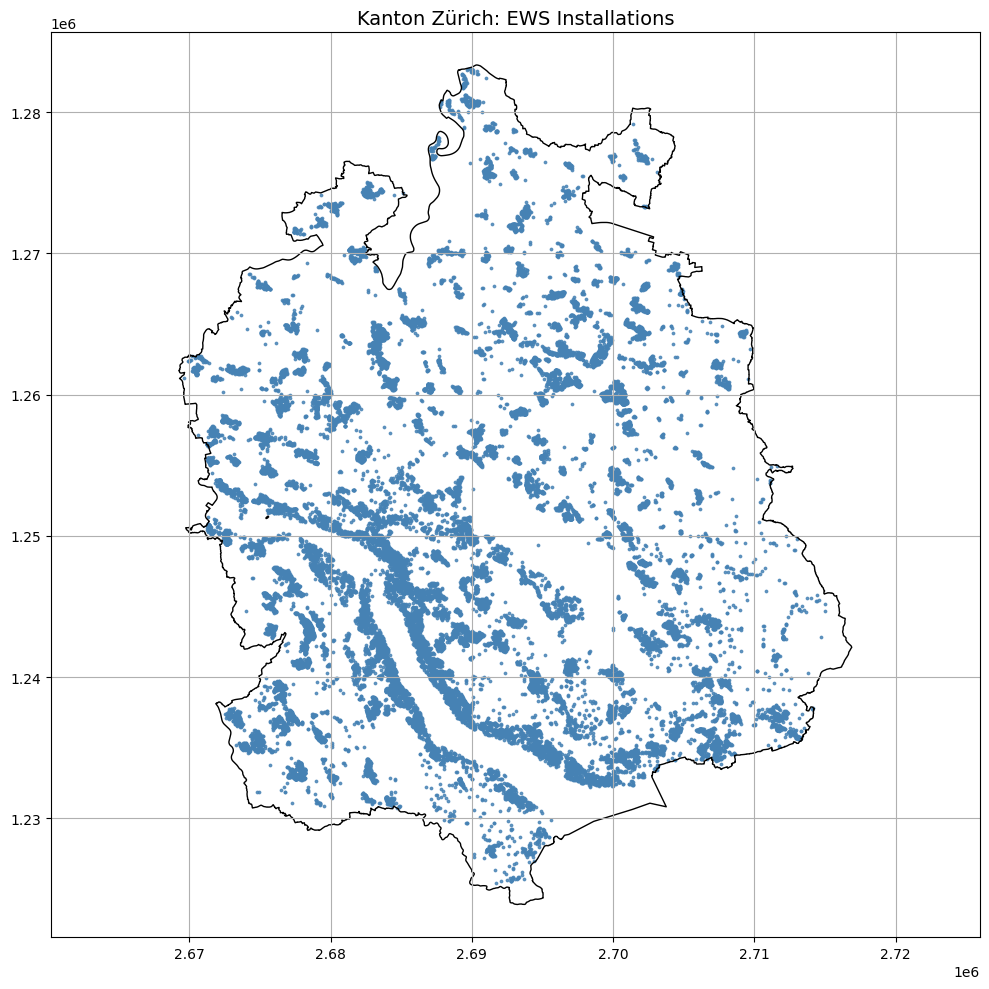

In [8]:
# Quick geographic plot
fig, ax = plt.subplots(figsize=(10, 10))
zh_geothermal_probes_gdf.plot(ax=ax, markersize=3, color="steelblue", alpha=0.8)

# Overlay canton boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

plt.title("Kanton Zürich: EWS Installations", fontsize=14)
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/03_01_zh_ews_map.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/03_01_zh_ews_map.png", format="png", dpi=300, bbox_inches="tight")
plt.show()